# Детекция и YOLO — часть 2

В этой части занятия мы загрузим предобученную модель, дообучим её на датасете из лиц и посмотрим на результаты.

## Установка библиотеки

Ultralytics — библиотека, в которой представлены современные модели компьютерного зрения для задач классификации изображений, обнаружения объектов, сегментации изображений и оценки позы. Пожалуй, главная серия моделей здесь — YOLO.

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.9 MB/s eta 0:00:0000:01


## Вспомогательная функция для визуализации

In [3]:
import random
import cv2
import matplotlib.pyplot as plt
import os

def visualize_comparison(model, img_dir):
    """
    model: объект YOLO (обученный или базовый)
    img_dir: путь к папке с изображениями (например, валидация)
    """
    
    # 1. Выбираем случайный файл
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    if not image_files:
        print("В папке нет изображений!")
        return
        
    random_file = random.choice(image_files)
    img_path = os.path.join(img_dir, random_file)
    
    # Определяем путь к лейблу (предполагаем стандартную структуру YOLO: .../images/val -> .../labels/val)
    # Если у вас папки называются иначе, поправьте replace
    label_path = img_path.replace('images', 'labels').rsplit('.', 1)[0] + '.txt'

    # 2. Готовим изображение Ground Truth (Ожидание)
    img_gt = cv2.imread(img_path)
    img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
    h, w, _ = img_gt.shape

    # Рисуем истинные боксы
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                # YOLO format: class x_center y_center width height
                data = list(map(float, line.strip().split()))
                # data[0] - класс, остальные - координаты
                x_c, y_c, bbox_w, bbox_h = data[1:]
                
                x1 = int((x_c - bbox_w / 2) * w)
                y1 = int((y_c - bbox_h / 2) * h)
                x2 = int((x_c + bbox_w / 2) * w)
                y2 = int((y_c + bbox_h / 2) * h)
                
                cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img_gt, "GT", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    else:
        print(f"Внимание: Файл разметки {label_path} не найден.")

    # 3. Готовим изображение Prediction (Реальность)
    # verbose=False, чтобы не засорять вывод текстом
    results = model.predict(img_path, verbose=False) 
    img_pred = results[0].plot() # Метод plot() сам рисует боксы и лейблы
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)

    # 4. Визуализация
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_gt)
    plt.title("Ground Truth (Истинная разметка)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_pred)
    # Выводим среднюю уверенность, если есть детекции
    conf_score = results[0].boxes.conf.mean() if len(results[0].boxes) > 0 else 0.0
    plt.title(f"Model Prediction\nAvg Confidence: {conf_score:.2f}")
    plt.axis('off')
    
    plt.show()
    print(f"Изображение: {random_file}")

# Пример использования до обучения (покажет плохой результат или детекцию обычных людей/предметов)
# visualize_comparison(model, dataset_yaml['val'])

## Настроим датасет

Для использования YOLO требуется датасет в определённом формате и YAML-файл, указывающий программе, где искать данные. Вот как он выглядит:

In [4]:
import yaml

dataset_yaml = {
    "train": "/kaggle/input/datasets/fareselmenshawii/face-detection-dataset/images/train",
    "val": "/kaggle/input/datasets/fareselmenshawii/face-detection-dataset/images/val",
    "nc": 1,
    "names": ["Face"]
}

with open("dataset.yaml", "w") as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False, sort_keys=False)

## Загрузим последнюю версию YOLO

Недавно вышла YOLO26. Выберем модель nano для скорости (yolo26n). Код ниже загрузит предобученную модель:

In [5]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo26n.pt")  # load a pretrained model (recommended for training)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Давайте посмотрим, как модель предсказывает bounding boxes для изображений сейчас.
(функция каждый раз берёт случайные изображения, так что можно запустить несколько раз)

Как работает модель ДО обучения (на данных COCO):


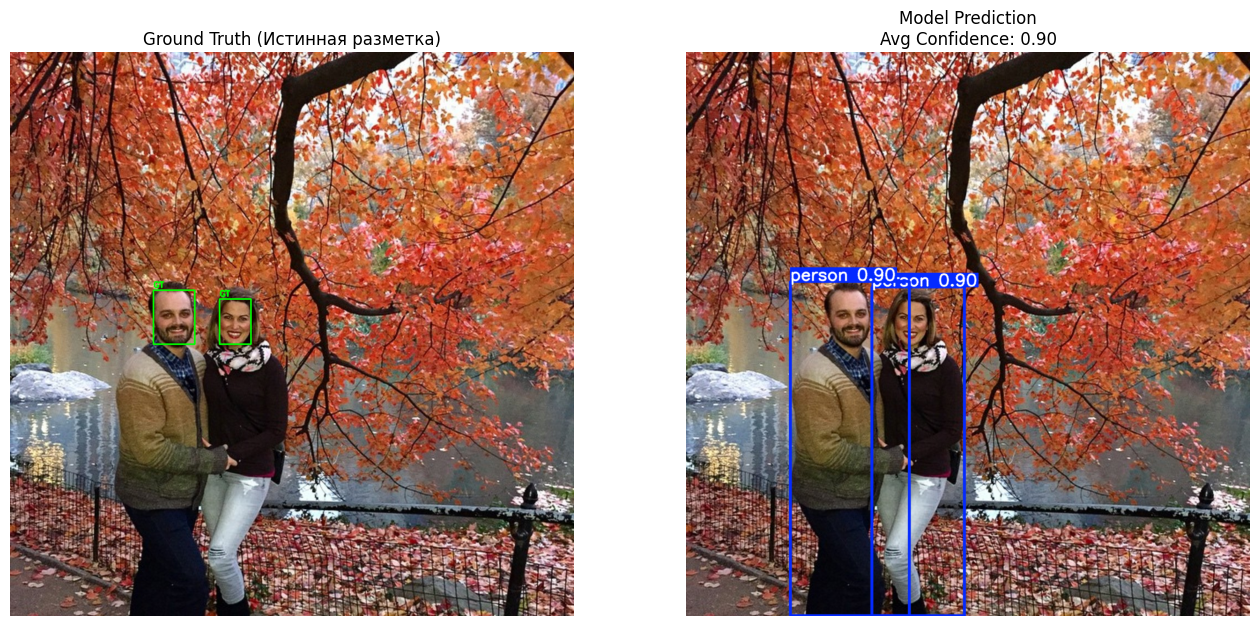

Изображение: 0bd9658e75ab6aa1.jpg


In [12]:
print("Как работает модель ДО обучения (на данных COCO):")
visualize_comparison(model, dataset_yaml['val'])

In [13]:
results = model.train(data="/kaggle/working/dataset.yaml", epochs=1, plots=True)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pe

Вот так выглядит код для предсказания:

In [14]:
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")
pred_path = '/kaggle/input/datasets/fareselmenshawii/face-detection-dataset/images/train/00006c07d2b033d1.jpg'
results = model.predict(pred_path, save=True)


image 1/1 /kaggle/input/datasets/fareselmenshawii/face-detection-dataset/images/train/00006c07d2b033d1.jpg: 640x640 2 Faces, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/runs/detect/predict


Как работает модель ПОСЛЕ обучения:


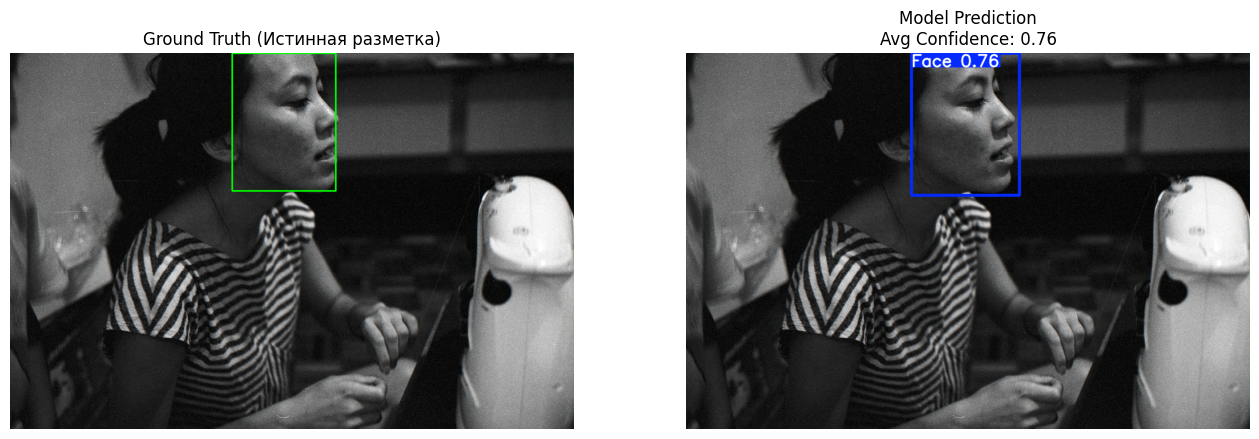

Изображение: d9791dd278d2c80f.jpg


In [20]:
print("Как работает модель ПОСЛЕ обучения:")
visualize_comparison(model, dataset_yaml['val'])

## Анализ результатов обучения

YOLO автоматически сохраняет графики обучения и примеры валидации. Давайте посмотрим на кривые потерь (Loss) и метрики точности (mAP), а также на то, как модель справлялась с батчами данных во время валидации.

Анализируем результаты из папки: /kaggle/working/runs/detect/train


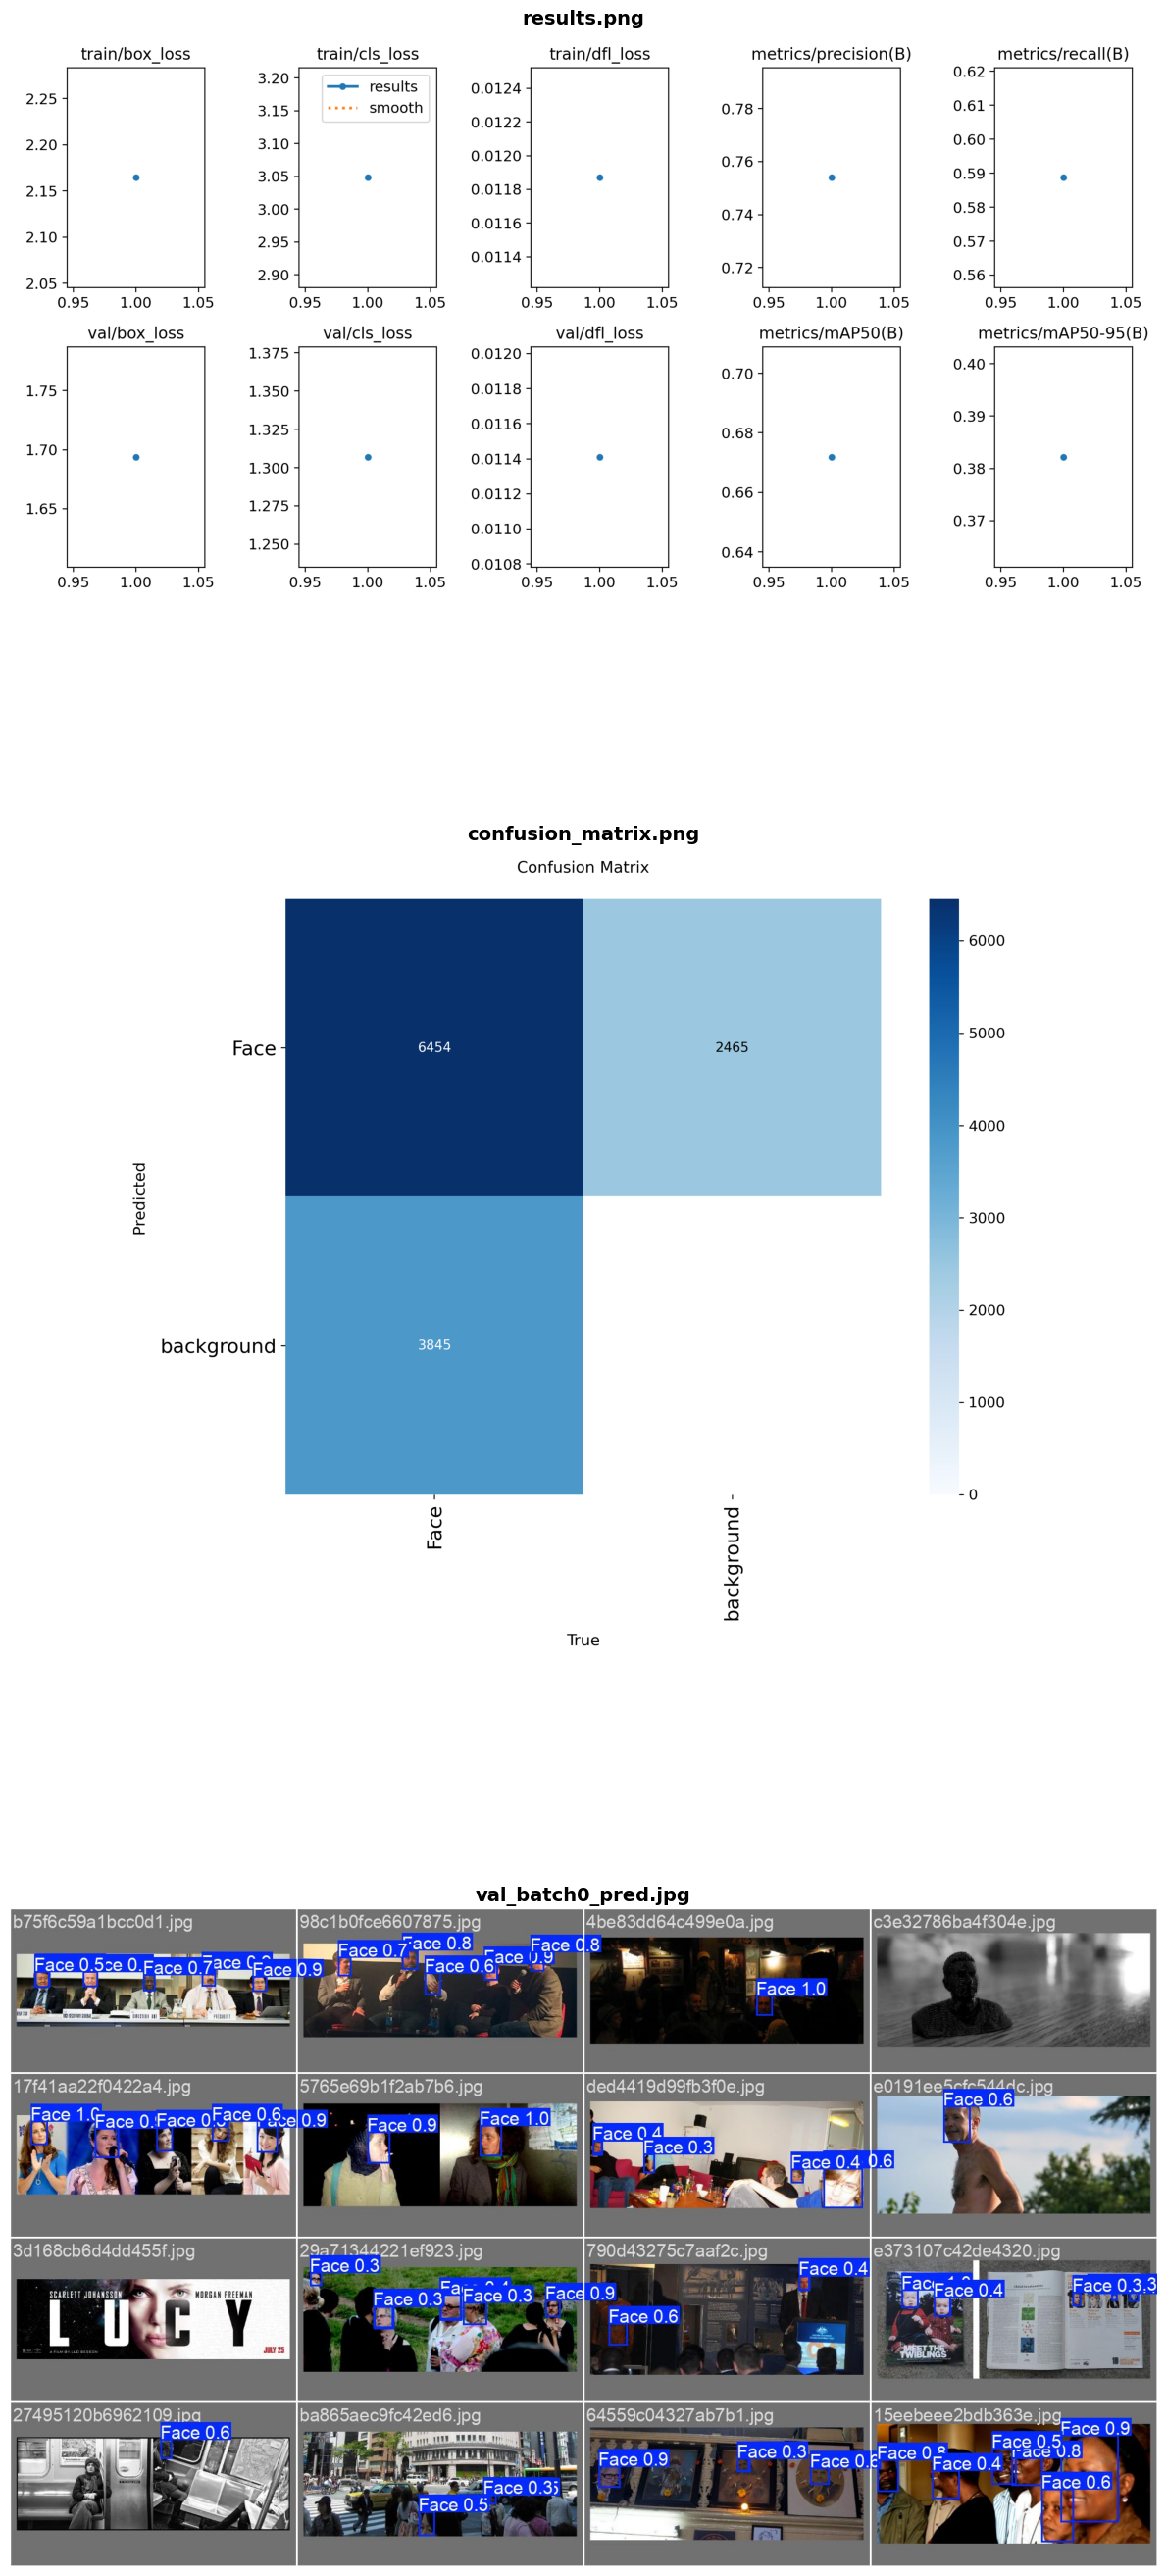

In [30]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Находим папку последнего запуска
runs_dir = '/kaggle/working/runs/detect'
# Проверка на существование папки (на случай, если обучение не запускалось)
if os.path.exists(runs_dir):
    train_dirs = [d for d in os.listdir(runs_dir) if d.startswith('train')]
    train_dirs.sort(key=lambda x: os.path.getmtime(os.path.join(runs_dir, x)))
    latest_run = os.path.join(runs_dir, train_dirs[-1])
    print(f"Анализируем результаты из папки: {latest_run}")

    # Список файлов для отображения
    files_to_show = ['results.png', 'confusion_matrix.png', 'val_batch0_pred.jpg']

    # Увеличиваем высоту фигуры (figsize), так как графики будут друг под другом
    plt.figure(figsize=(12, 30)) 

    for i, file_name in enumerate(files_to_show):
        file_path = os.path.join(latest_run, file_name)
        
        # Создаем подграфик: 3 строки, 1 столбец, текущий индекс
        plt.subplot(len(files_to_show), 1, i + 1)
        
        if os.path.exists(file_path):
            img = mpimg.imread(file_path)
            plt.imshow(img)
            plt.title(file_name, fontsize=14, fontweight='bold')
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, f"Файл {file_name} не найден", 
                     ha='center', va='center', fontsize=12)
            plt.axis('off')

    plt.tight_layout() # Чтобы заголовки не наезжали на картинки
    plt.show()
else:
    print("Папка с результатами не найдена. Сначала запустите обучение (model.train).")

## Упражнение: Счётчик лиц

Представьте, что вы делаете систему пропускного контроля. Вам нужно не просто нарисовать рамку, а получить число людей в кадре.
В объекте results[0] (первый результат для первого фото) есть свойство .boxes, которое хранит все найденные рамки.
Напишите код, который считает количество найденных лиц на случайном фото.

Файл: 96cb996f60c3e078.jpg
Модель нашла лиц: None


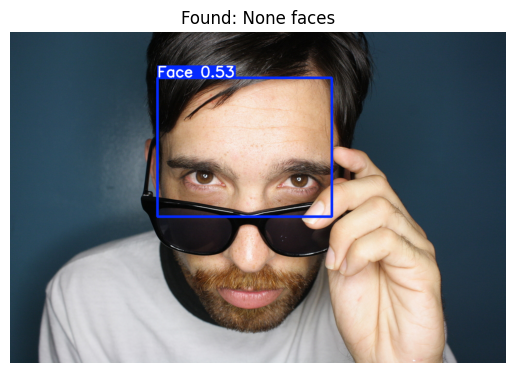

❌ Что-то не так


In [29]:
val_img_path = dataset_yaml['val']
image_files = [f for f in os.listdir(val_img_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
if not image_files:
    print("В папке нет изображений!")

# Берем новое случайное фото

random_file_task = random.choice(image_files)
img_task_path = os.path.join(val_img_path, random_file_task)

# Делаем предсказание с порогом уверенности 0.5 (conf=0.5)
results_task = model.predict(img_task_path, conf=0.5, verbose=False)

# --- ВАШ КОД НИЖЕ ---
# Задание: Присвойте переменной faces_count количество найденных рамок
# Подсказка: используйте len() к объекту results_task[0].boxes

faces_count = None # Удалите None и напишите ваш код

# --------------------

# Проверка
print(f"Файл: {random_file_task}")
print(f"Модель нашла лиц: {faces_count}")

# Визуализация для проверки
plt.imshow(cv2.cvtColor(results_task[0].plot(), cv2.COLOR_BGR2RGB))
plt.title(f"Found: {faces_count} faces")
plt.axis('off')
plt.show()

if faces_count is not None and faces_count == len(results_task[0].boxes):
    print("✅ Отлично! Вы научились извлекать данные из предсказания.")
else:
    print("❌ Что-то не так")